# CNN을 이용한 문서 분류
- 이미지 분류에 주로 사용되는 CNN이 문서 분류에도 성능이 좋아 텍스트 마이닝에도 사용됨
- 이미지 분류와의 차이점: 이미지 분류는 필터가 상하좌우 방향(즉, 2차원)으로 움직이지만, **문서의 경우 한방향(1차원)**으로 움직임
- 따라서 keras로 모델을 구축할 때, Con2D가 아닌 Con1D를 이용
<br/> <br/>
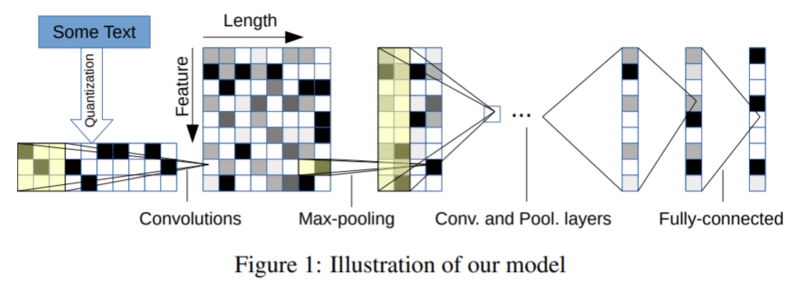
<br/> 

## CNN을 이용한 NLTK 영화 리뷰 분류

In [1]:
from nltk.corpus import movie_reviews
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split 

physical_devices = tf.config.list_physical_devices('GPU')

try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    #tf.config.experimental.set_memory_growth(physical_devices[1], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

In [2]:
#movie review data에서 file id를 가져옴
fileids = movie_reviews.fileids() 
#file id를 이용해 raw text file을 가져옴
reviews = [movie_reviews.raw(fileid) for fileid in fileids] 
categories = [movie_reviews.categories(fileid)[0] for fileid in fileids] 

print(len(reviews))
print(set(categories))

2000
{'neg', 'pos'}


In [3]:
np.random.seed(7)
tf.random.set_seed(7)

max_words = 10000           #사용할 단어의 수
maxlen = 500                #문서의 단어 수를 제한

# 빈도가 높은 10000개의 단어를 선택하도록 객체 생성
tokenizer = Tokenizer(num_words=max_words, oov_token='UNK') 
tokenizer.fit_on_texts(reviews) #단어 인덱스 구축

X = tokenizer.texts_to_sequences(reviews) #만들어진 단어 인덱스를 이용해 변환
X = pad_sequences(X, maxlen=maxlen, truncating='pre') 

# label을 0, 1의 값으로 변환
label_dict = {'pos':0, 'neg':1}
y = np.array([label_dict[c] for c in categories])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [4]:
# 모델 생성

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D
from tensorflow.keras.layers import Embedding, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

model = Sequential([
    #word embedding layer 생성
    Embedding(max_words, 64, input_length=maxlen), 
    Conv1D(128, # 채널의 수
            5, # 1D 필터 크기
            padding='valid', 
            activation='relu',
            strides=1), 
    MaxPooling1D(),
    
    Conv1D(256, # 채널의 수
            5, # 1D 필터 크기
            padding='valid', 
            activation='relu',
            strides=1), 
    MaxPooling1D(),
    
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid') #binary logistic regression을 수행
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 64)           640000    
                                                                 
 conv1d (Conv1D)             (None, 496, 128)          41088     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 248, 128)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 244, 256)          164096    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 122, 256)         0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 31232)             0

In [5]:
adam = Adam(learning_rate=1e-3)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc'])

In [6]:
history = model.fit(X_train, y_train, 
                    epochs=20,
                    batch_size=256,
                    verbose=0,
                    validation_split=0.2)

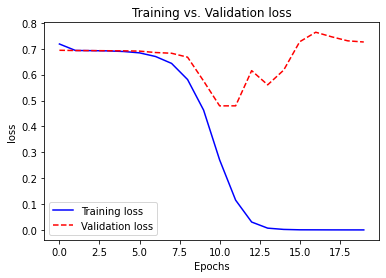

13/13 [==============================] - 0s 27ms/step - loss: 0.6970 - acc: 0.8050
#Test accuracy:0.805


In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_results(history, metric):
    plt.plot(history.history[metric], 'b', label='Training '+metric)
    plt.plot(history.history['val_'+metric], 'r--', label='Validation '+metric)
    plt.title('Training vs. Validation '+metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

plot_results(history, 'loss')

#테스트 셋으로 학습된 모형의 성능을 평가
score = model.evaluate(X_test, y_test)
print(f'#Test accuracy:{score[1]:.3f}')